# Analysis of AdaTempScal on ResNet50 for CIFAR10

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1

In [37]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

%aimport models
from models import AdaptiveTempScaling, TempScaling
%aimport utils
from utils import compare_results, calib_split, get_CIFAR10_C, NumpyDataset, load_model, predict_logits, compute_metrics

In [5]:
%matplotlib inline

In [6]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

## Load data and precomputed logits

In [7]:
CIFAR10_PATH = '../../data/CIFAR10'
CIFAR10C_PATH = '../../data/CIFAR-10-C'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [8]:
X_train = np.load(os.path.join(CIFAR10_PATH, 'train_imas.npy'))
y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))

X_val = np.load(os.path.join(CIFAR10_PATH, 'val_imas.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))

X_test = np.load(os.path.join(CIFAR10_PATH, 'test_imas.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [9]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

### Calibrate models

In [10]:
N, dim = Z_train.shape

### Temp-Scal as baseline:
tempScaler = TempScaling()
tempScaler.fit(Z_val, y_val, v=True);

In [11]:
aTempScaler = AdaptiveTempScaling(dim)
aTempScaler.fit(Z_val, y_val, v=True, lr=1e-1, epochs=10000);

Finding optimum Temperature
On epoch: 774, NLL: 2.172e+03, Temp: 2.575, at time: 6.82s

Adapting Weight vector
On epoch: 9994, loss: 2.143e+03, at time: 182.99s



In [12]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         99.94          0.11     1.104e-03     1.215e+02
    TempScal         99.94          5.35     8.604e-03     2.615e+03
AdaptiveTempScal         99.94          5.72     9.887e-03     2.811e+03


In [13]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_val)}, target=y_val, M=15, from_logits=False);

##### Results on validation set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         86.72         10.30     2.300e-01     3.868e+03
    TempScal         86.72          2.49     1.967e-01     2.172e+03
AdaptiveTempScal         86.72          2.25     1.947e-01     2.143e+03


In [14]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_test)}, target=y_test, M=15, from_logits=False);

##### Results on test set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         86.13         10.69     2.392e-01     7.897e+03
    TempScal         86.13          2.35     2.037e-01     4.473e+03
AdaptiveTempScal         86.13          2.25     2.019e-01     4.414e+03


### Temperature distribution

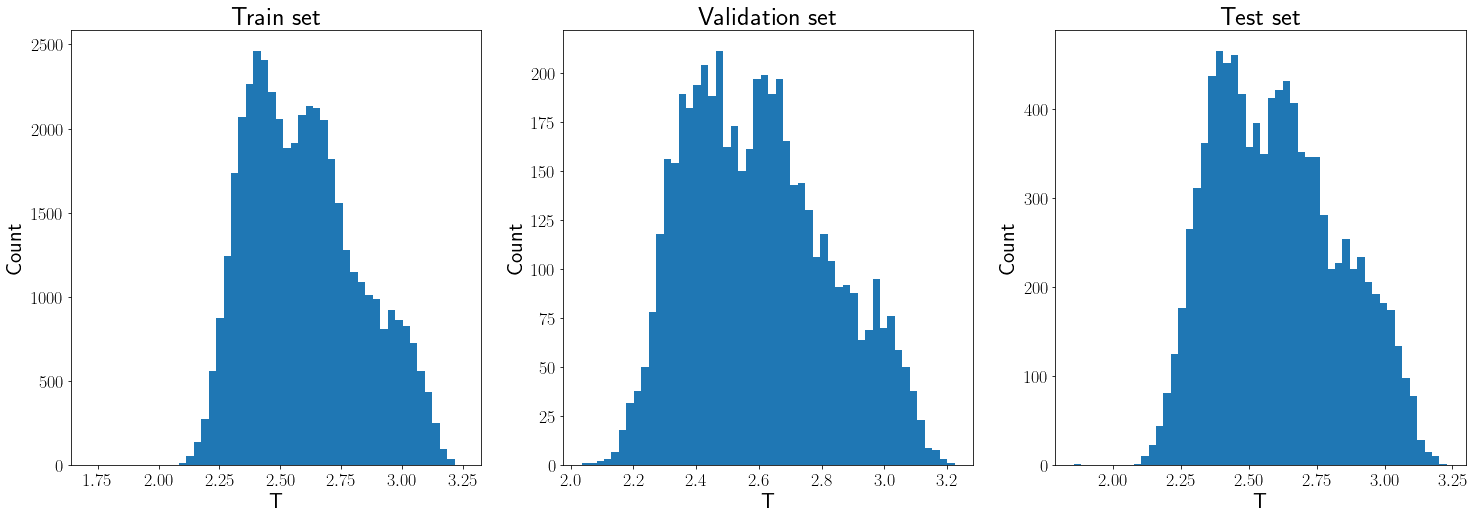

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

Ts = aTempScaler.get_T(Z_train)
ax[0].hist(Ts, bins=50)
ax[0].set_xlabel('T', fontsize=22)
ax[0].set_ylabel('Count', fontsize=22)
ax[0].set_title('Train set', fontsize=26)

Ts = aTempScaler.get_T(Z_val)
ax[1].hist(Ts, bins=50)
ax[1].set_xlabel('T', fontsize=22)
ax[1].set_ylabel('Count', fontsize=22)
ax[1].set_title('Validation set', fontsize=26)

Ts = aTempScaler.get_T(Z_test)
ax[2].hist(Ts, bins=50)
ax[2].set_xlabel('T', fontsize=22)
ax[2].set_ylabel('Count', fontsize=22)
ax[2].set_title('Test set', fontsize=26)

for _ax in ax.flatten():
    _ax.tick_params(axis='both', labelsize=18)
    

plt.show()

### Selected temperature for different confidences in test set

In [16]:
hc, lc, hi, li = calib_split(Z_test, y_test)

ts_aux = TempScaling()
ts_aux.fit(Z_test[hc | hi], y_test[hc | hi]);
T_hc = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[lc | li], y_test[lc | li]);
T_lc = ts_aux.T.detach().numpy()


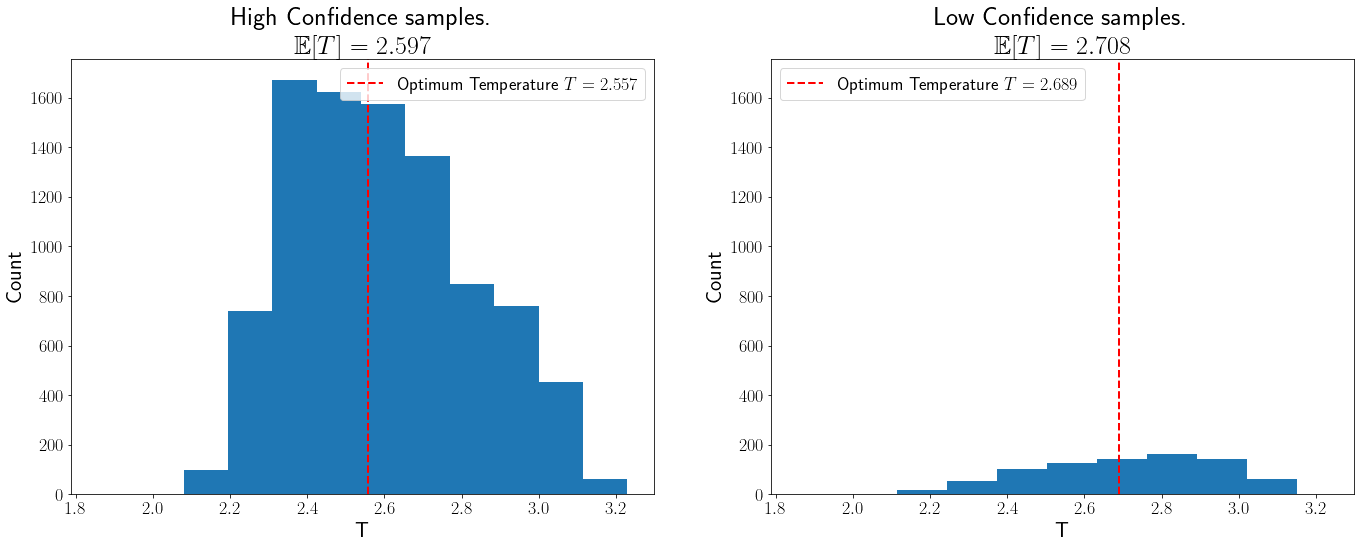

In [17]:
Ts = aTempScaler.get_T(Z_test)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(23, 8))


ax[0].hist(Ts[hc | hi])
ax[0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc | hi])), fontsize=26)
ax[0].legend(fontsize=18)



ax[1].hist(Ts[lc | li])
ax[1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[lc | li])), fontsize=26)
ax[1].legend(fontsize=18)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
plt.show();

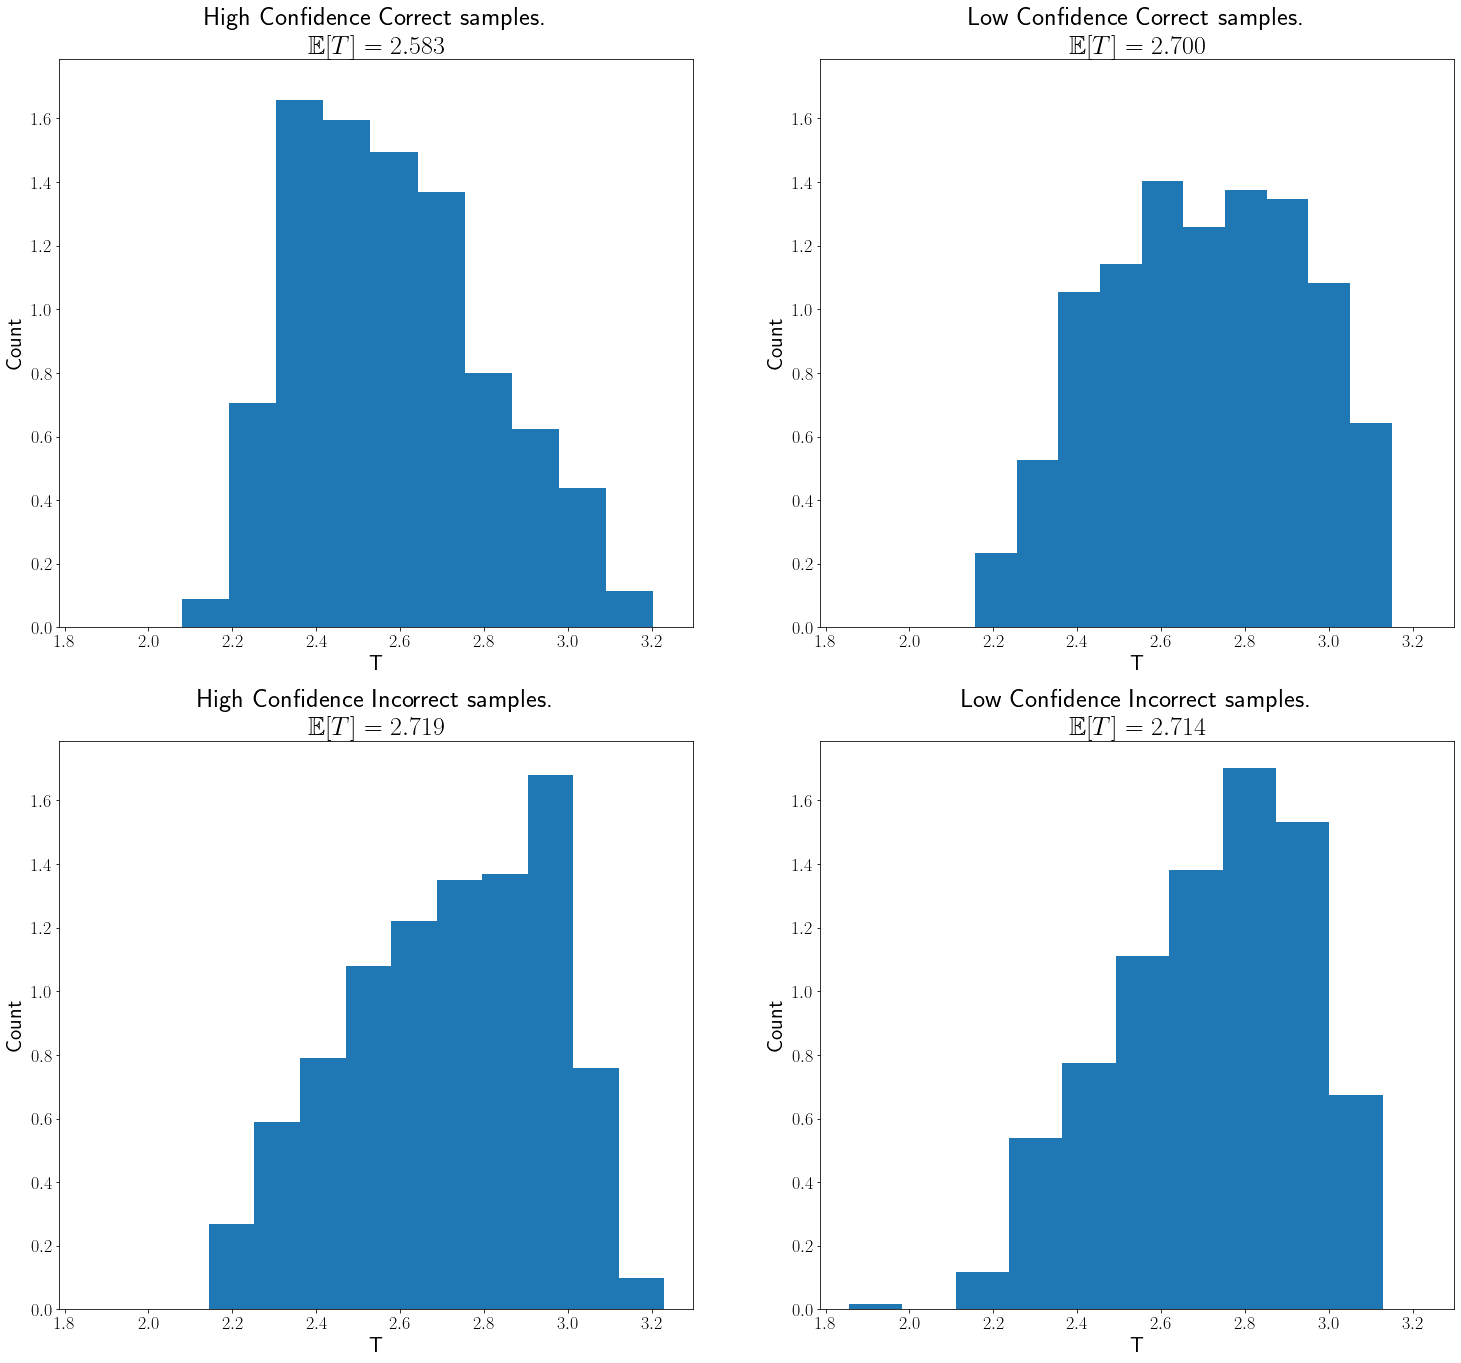

In [18]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(25, 23))


ax[0, 0].hist(Ts[hc], density=True)
ax[0, 0].set_title('High Confidence Correct samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc])), fontsize=26)

ax[0, 1].hist(Ts[lc], density=True)
ax[0, 1].set_title('Low Confidence Correct samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[lc])), fontsize=26)


ax[1, 0].hist(Ts[hi], density=True)
ax[1, 0].set_title('High Confidence Incorrect samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hi])), fontsize=26)

ax[1, 1].hist(Ts[li], density=True)
ax[1, 1].set_title('Low Confidence Incorrect samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[li])), fontsize=26)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
plt.show();

### According to quantiles

In [19]:
test_probs = softmax(Z_test, axis=1)
test_confs = np.max(test_probs, axis=1)

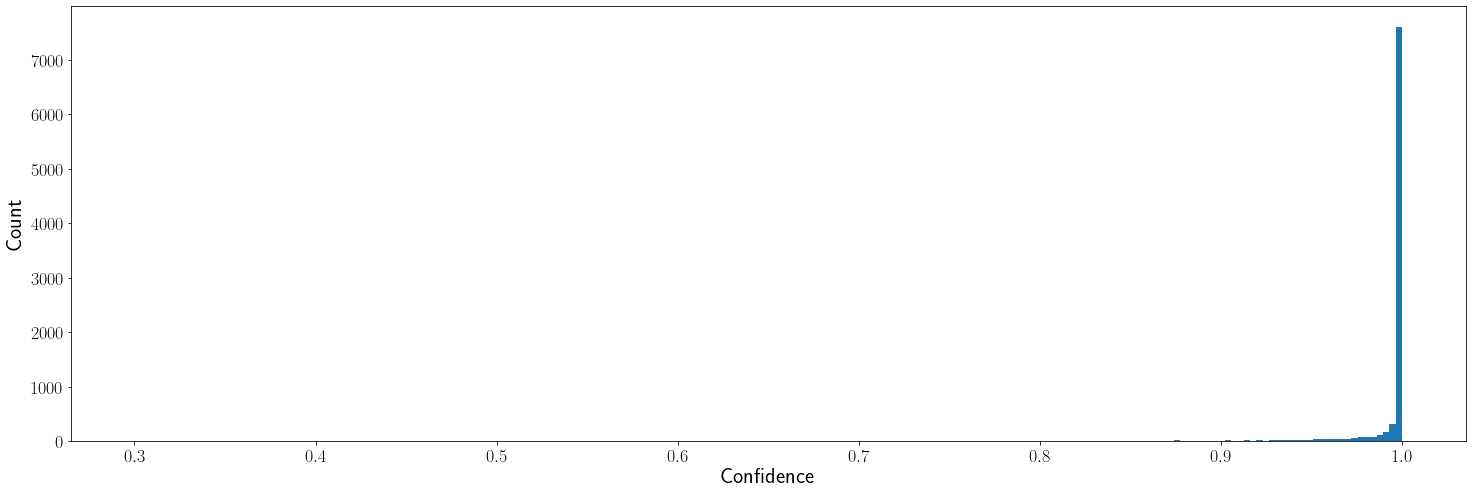

In [20]:
fig, ax = plt.subplots(figsize=(25, 8))

ax.hist(test_confs, bins=200)

ax.set_xlabel('Confidence', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
ax.tick_params(axis='both', labelsize=18)

plt.show();

In [21]:
ix = np.argsort(test_confs)

q1, q2, q3, q4 = ix[:len(test_confs)//4], ix[len(test_confs)//4:len(test_confs)//2], ix[len(test_confs)//2: 3*len(test_confs)//4], ix[3*len(test_confs)//4:]


ts_aux = TempScaling()
ts_aux.fit(Z_test[q1], y_test[q1]);
T_q1 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q2], y_test[q2]);
T_q2 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q3], y_test[q3]);
T_q3 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q4], y_test[q4]);
T_q4 = ts_aux.T.detach().numpy()



Ts = aTempScaler.get_T(Z_test)

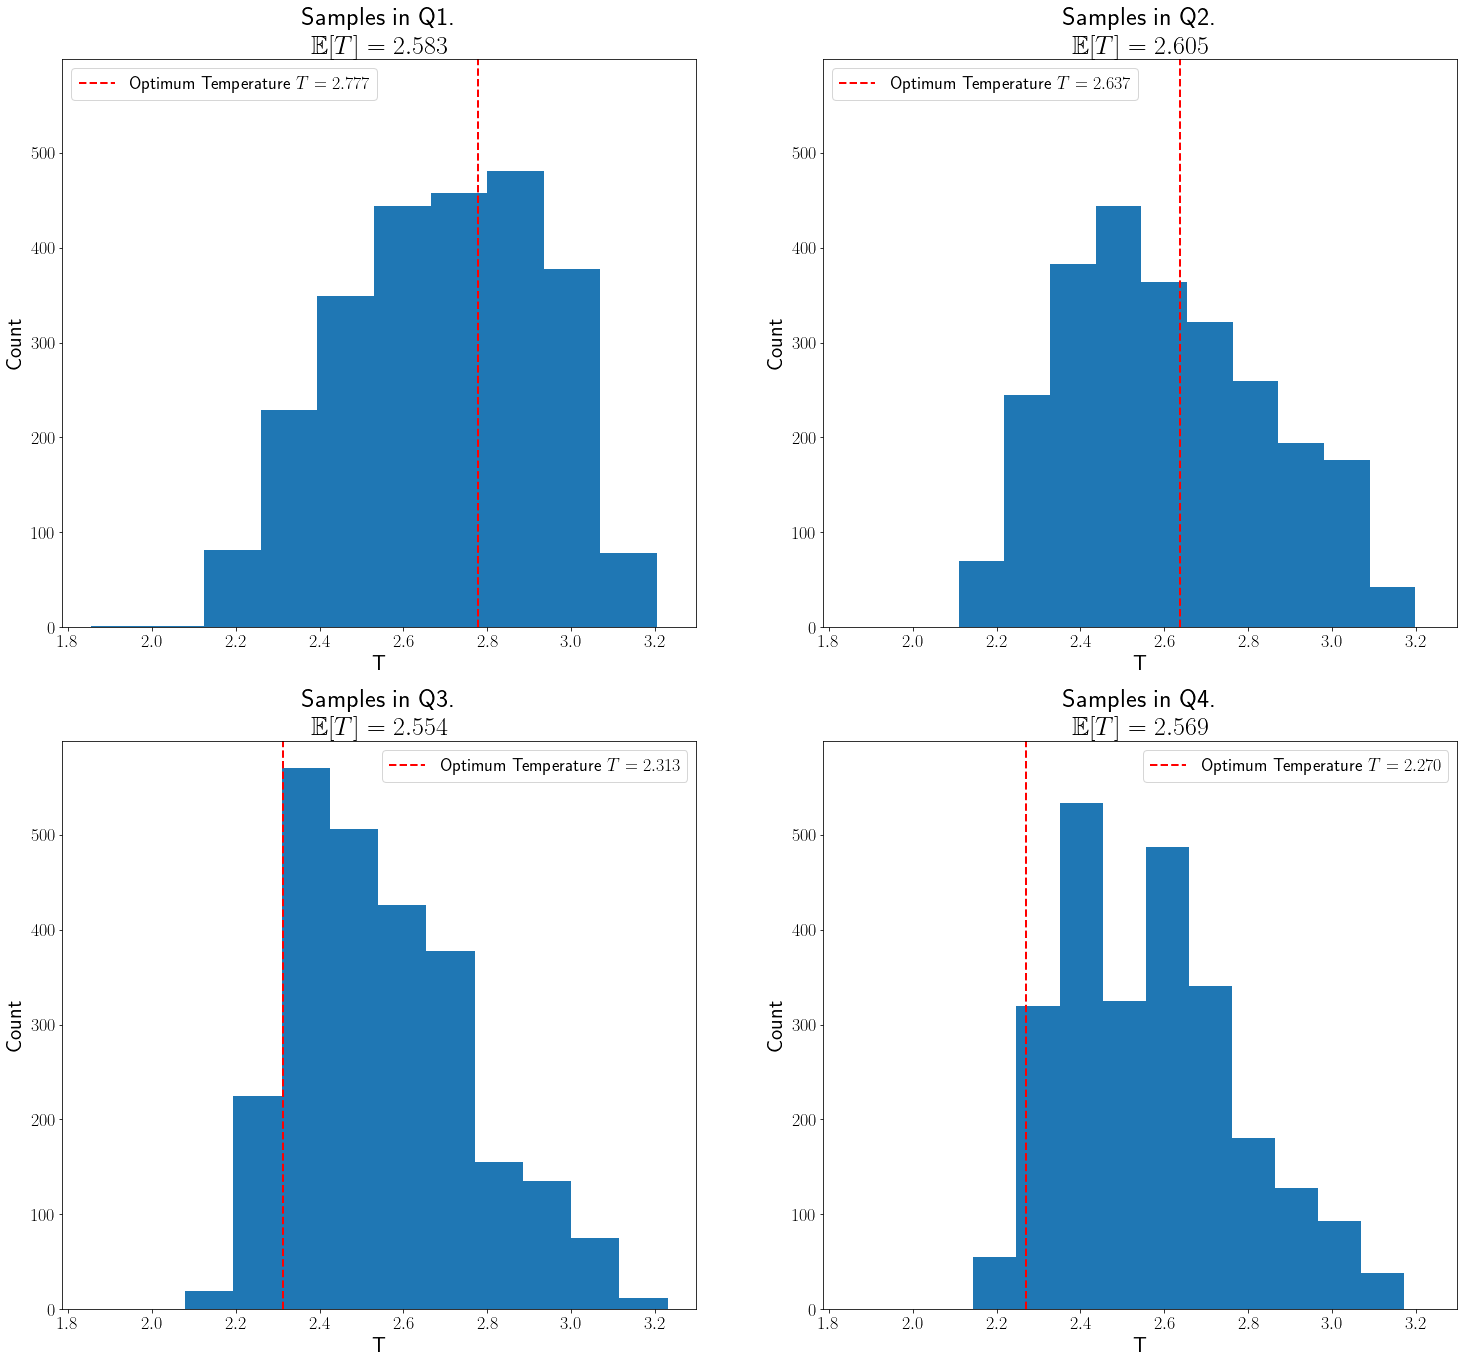

In [22]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(25, 23))


ax[0, 0].hist(Ts[q1])
ax[0, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[0, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc])), fontsize=26)


ax[0, 1].hist(Ts[q2])
ax[0, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[0, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q2])), fontsize=26)


ax[1, 0].hist(Ts[q3])
ax[1, 0].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[1, 0].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q3])), fontsize=26)


ax[1, 1].hist(Ts[q4])
ax[1, 1].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[1, 1].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q4])), fontsize=26)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.legend(fontsize=18)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)

plt.show();

## Corruption Robustness: CIFAR10-C

In [23]:
cifar10c = get_CIFAR10_C(CIFAR10C_PATH)

categories = list(cifar10c.keys())
categories.remove('labels')

In [24]:
cifar10_transforms_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [29]:
net = load_model('resnet50', 'cifar10', model_path='../../trained_models') 

In [35]:
cifar10c_logits = {}

for category in categories:
    cifar10c_logits[category] = {}
    print('Computing predictions for corruption: {}'.format(category))
    for severity in range(1, 6):
        test_data = NumpyDataset(cifar10c[category][severity], cifar10c['labels'][:10000], transform=cifar10_transforms_test)
        test_dataloader = DataLoader(test_data, batch_size=256)
        cifar10c_logits[category][severity] = predict_logits(net, test_dataloader, torch.device('cuda'))

Computing predictions for corruption: brightness
Computing predictions for corruption: contrast
Computing predictions for corruption: defocus_blur
Computing predictions for corruption: elastic_transform
Computing predictions for corruption: fog
Computing predictions for corruption: frost
Computing predictions for corruption: gaussian_blur
Computing predictions for corruption: gaussian_noise
Computing predictions for corruption: glass_blur
Computing predictions for corruption: impulse_noise
Computing predictions for corruption: jpeg_compression
Computing predictions for corruption: motion_blur
Computing predictions for corruption: pixelate
Computing predictions for corruption: saturate
Computing predictions for corruption: shot_noise
Computing predictions for corruption: snow
Computing predictions for corruption: spatter
Computing predictions for corruption: speckle_noise
Computing predictions for corruption: zoom_blur


In [53]:
cifar10c_metrics_uncal = {}
cifar10c_metrics_tscal = {}
cifar10c_metrics_atscal = {}

for category in categories:
    cifar10c_metrics_uncal[category] = {}
    cifar10c_metrics_tscal[category] = {}
    cifar10c_metrics_atscal[category] = {}
    print('Computing metrics for corruption: {}'.format(category))
    for severity in range(1, 6):
        cifar10c_metrics_uncal[category][severity] = compute_metrics(cifar10c_logits[category][severity], cifar10c['labels'][:10000])
        cifar10c_metrics_tscal[category][severity] = compute_metrics(tempScaler.predictive(cifar10c_logits[category][severity]), cifar10c['labels'][:10000], from_logits=False)
        cifar10c_metrics_atscal[category][severity] = compute_metrics(aTempScaler.predictive(cifar10c_logits[category][severity]), cifar10c['labels'][:10000], from_logits=False)

Computing metrics for corruption: brightness
Computing metrics for corruption: contrast
Computing metrics for corruption: defocus_blur
Computing metrics for corruption: elastic_transform
Computing metrics for corruption: fog
Computing metrics for corruption: frost
Computing metrics for corruption: gaussian_blur
Computing metrics for corruption: gaussian_noise
Computing metrics for corruption: glass_blur
Computing metrics for corruption: impulse_noise
Computing metrics for corruption: jpeg_compression
Computing metrics for corruption: motion_blur
Computing metrics for corruption: pixelate
Computing metrics for corruption: saturate
Computing metrics for corruption: shot_noise
Computing metrics for corruption: snow
Computing metrics for corruption: spatter
Computing metrics for corruption: speckle_noise
Computing metrics for corruption: zoom_blur


In [73]:
mean_sev_uncal = np.zeros((5, 4))
mean_sev_tscal = np.zeros((5, 4))
mean_sev_atscal = np.zeros((5, 4))


for i in range(5):
    for cat in categories:
        mean_sev_uncal[i] += cifar10c_metrics_uncal[cat][i+1]
        mean_sev_tscal[i] += cifar10c_metrics_tscal[cat][i+1]
        mean_sev_atscal[i] += cifar10c_metrics_atscal[cat][i+1]
        
mean_sev_uncal /= len(categories)
mean_sev_tscal /= len(categories)
mean_sev_atscal /= len(categories)

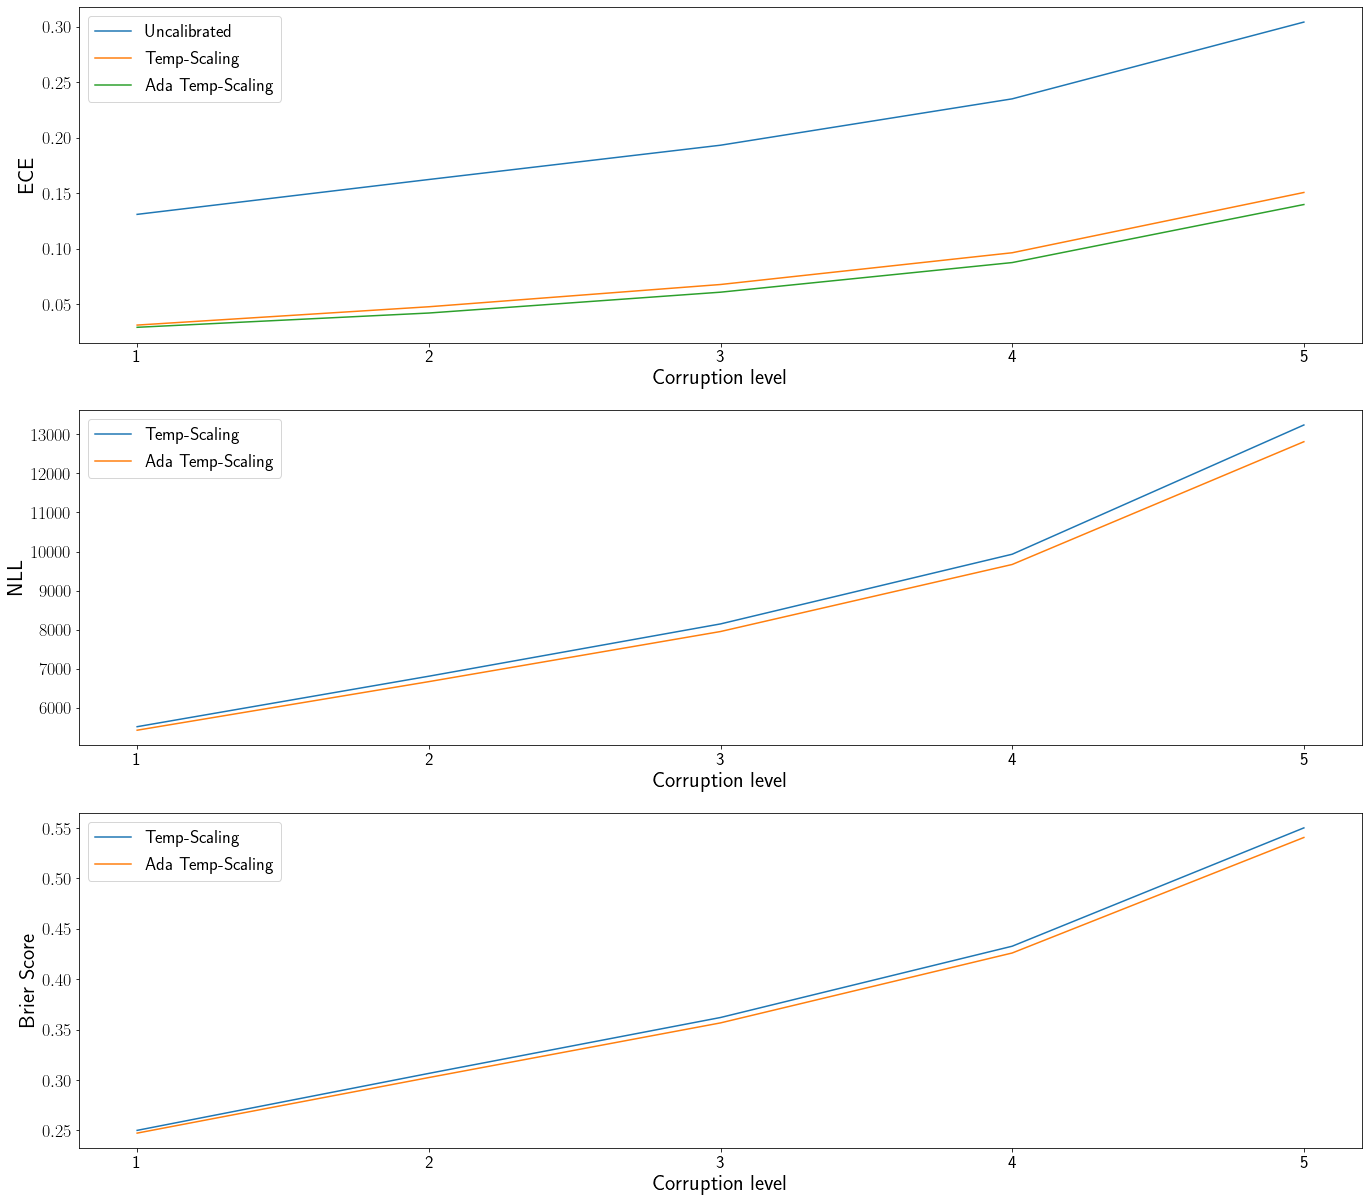

In [79]:
fig, ax = plt.subplots(3, 1, figsize=(23, 21))

ax[0].plot(mean_sev_uncal[:, 1], label='Uncalibrated')
ax[0].plot(mean_sev_tscal[:, 1], label='Temp-Scaling')
ax[0].plot(mean_sev_atscal[:, 1], label='Ada Temp-Scaling')
ax[0].set_ylabel('ECE', fontsize=22)

# ax[1].plot(mnll_sev_uncal, label='Uncalibrated')
ax[1].plot(mean_sev_tscal[:, 3], label='Temp-Scaling')
ax[1].plot(mean_sev_atscal[:, 3], label='Ada Temp-Scaling')
ax[1].set_ylabel('NLL', fontsize=22)

ax[2].plot(mean_sev_tscal[:, 2], label='Temp-Scaling')
ax[2].plot(mean_sev_atscal[:, 2], label='Ada Temp-Scaling')
ax[2].set_ylabel('Brier Score', fontsize=22)

for _ax in ax.flatten():
    _ax.set_xticks(np.arange(5))
    _ax.set_xticklabels(np.arange(5) + 1)
    _ax.legend(fontsize=18)
    _ax.tick_params(axis='both', labelsize=18)
    _ax.set_xlabel('Corruption level', fontsize=22)

plt.show()

In [83]:
cifar10c_Ts= {}

for category in categories:
    cifar10c_Ts[category] = {}
    print('Computing Ts for corruption: {}'.format(category))
    for severity in range(1, 6):
        cifar10c_Ts[category][severity] = aTempScaler.get_T(cifar10c_logits[category][severity])

Computing Ts for corruption: brightness
Computing Ts for corruption: contrast
Computing Ts for corruption: defocus_blur
Computing Ts for corruption: elastic_transform
Computing Ts for corruption: fog
Computing Ts for corruption: frost
Computing Ts for corruption: gaussian_blur
Computing Ts for corruption: gaussian_noise
Computing Ts for corruption: glass_blur
Computing Ts for corruption: impulse_noise
Computing Ts for corruption: jpeg_compression
Computing Ts for corruption: motion_blur
Computing Ts for corruption: pixelate
Computing Ts for corruption: saturate
Computing Ts for corruption: shot_noise
Computing Ts for corruption: snow
Computing Ts for corruption: spatter
Computing Ts for corruption: speckle_noise
Computing Ts for corruption: zoom_blur


In [85]:
mean_Ts = np.zeros(5)
for i in range(5):
    for cat in categories:
        mean_Ts[i] += np.mean(cifar10c_Ts[cat][i+1])

In [87]:
mean_Ts

array([49.7415278 , 49.99471974, 50.19624686, 50.34870672, 50.59681797])